In [ ]:
!pip install darts

In [ ]:
from darts import TimeSeries
import pandas as pd

In [ ]:
def getDf(path):
  df = pd.read_excel(path, skiprows=3, usecols='B:O')
  df = df.dropna(axis=0, how='all')
  transposed_df = df.T
  transposed_df.columns = transposed_df.iloc[0]  # Set the first row as header
  transposed_df = transposed_df.drop(transposed_df.index[0])
  transposed_df['Period End Date'] = pd.to_datetime(transposed_df['Period End Date'])
  transposed_df = transposed_df.reset_index(drop=True)
  transposed_df.set_index('Period End Date', inplace=True)

  transposed_df.reset_index(inplace=True)

  return transposed_df

def combine_multiple_dfs(filenames):
  dfs = [getDf(filename) for filename in filenames]

  if not dfs:
      return pd.DataFrame()

  # Extract the Period End Date column from the first DataFrame
  date_column = dfs[0][['Period End Date']]

  # Remove the Period End Date column from all DataFrames
  processed_dfs = []
  for df in dfs:
      # Verify dates match
      if not df['Period End Date'].equals(date_column['Period End Date']):
          raise ValueError("Period End Date columns don't match across files")
      # Keep all columns except Period End Date
      processed_dfs.append(df.drop(columns=['Period End Date']))

  # Combine all processed DataFrames horizontally
  combined = pd.concat(processed_dfs, axis=1)

  # Add back the Period End Date column at the start
  final_df = pd.concat([date_column, combined], axis=1)

  return final_df

In [ ]:
filenames = ['/content/Source0' + str(i) + '.xlsx' for i in range(6)]
filenames.remove('/content/Source01.xlsx')

df = combine_multiple_dfs(filenames)

data_tail = df.tail(1)

# df = df[:-1]

df['Event Ticket Sales'] = df['Event Ticket Sales']

df.head()

Quarter,Period End Date,Total Revenue,Event Ticket Sales,"Food, Beverage, and Merchandise Sales",Box Office Sales,Advertising Sales,Observed Foot Traffic,Number of Concerts,Average Number of Attendees,Average Percent Occupancy,Total Observed Ads,Camera One Observed Ads,Camera Two Observed Ads,Camera Three Observed Ads,Total Tourists
0,2021-09-30,4087000,2062500,754500,500000,770000,27000,23,18750,0.75,77,26,19,32,1010000
1,2021-12-31,3702981,1846300,720760,475000,660921,26190,20,18500,0.74,69,24,17,28,981432
2,2022-03-31,3140139,1623225,687240,375000,454674,24880,20,17250,0.69,51,17,12,22,941690
3,2022-06-30,3341434,1688025,719230,400000,534179,25552,21,17750,0.71,57,19,14,24,967464
4,2022-09-30,4971695,2654340,945460,600000,771895,26998,25,20500,0.82,79,27,19,33,1022240


<Axes: xlabel='Period End Date'>

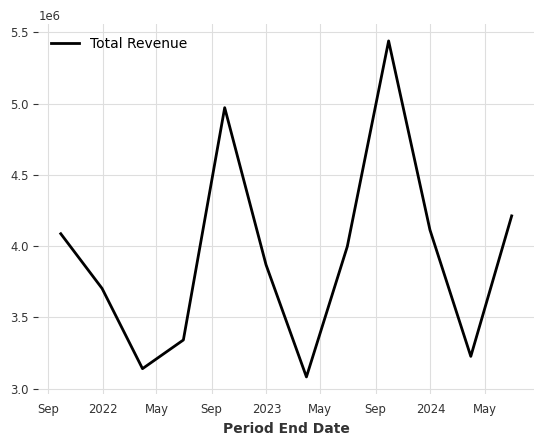

In [ ]:
series = TimeSeries.from_dataframe(df, time_col='Period End Date', value_cols='Total Revenue', fillna_value=0)
series, _ = series.split_after(11)
train, val = series.split_after(7)
series.plot(label='Total Revenue')

In [ ]:
transaction_df = pd.read_excel('/content/Source01.xlsx', skiprows=3, usecols='B:C')
transaction_df['Month Beginning'] = pd.to_datetime(transaction_df['Month Beginning'])

transaction_df.head()

,Month Beginning,Observed Transactions
0,2021-06-01,12341.4291
1,2021-07-01,35700.0000
2,2021-08-01,34700.0000
3,2021-09-01,29600.0000
4,2021-10-01,19800.0000


In [ ]:
transaction_series_monthly = TimeSeries.from_dataframe(transaction_df, time_col='Month Beginning', value_cols='Observed Transactions', fillna_value=0)

transaction_df = transaction_series_monthly.pd_dataframe().resample(series.freq).sum()

transaction_df = TimeSeries.from_dataframe(quarterly_df)

# quarterly_resampled.plot(label='Total Revenue')

component,Observed Transactions
Month Beginning,
2021-06-30,12341.429100
2021-09-30,100000.000000
2021-12-31,99000.000000
2022-03-31,97020.000000
2022-06-30,99930.600000
2022-09-30,114920.190000
2022-12-31,108024.978600
2023-03-31,102623.729670
2023-06-30,128279.662088


<Axes: xlabel='Period End Date'>

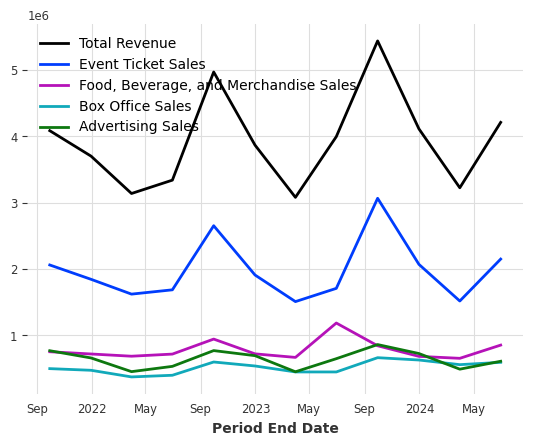

In [ ]:
revenue_series = TimeSeries.from_dataframe(df, time_col='Period End Date', value_cols='Total Revenue', fillna_value=0)

ticket_series = TimeSeries.from_dataframe(df, time_col='Period End Date', value_cols='Event Ticket Sales', fillna_value=0)

merch_series = TimeSeries.from_dataframe(df, time_col='Period End Date', value_cols='Food, Beverage, and Merchandise Sales', fillna_value=0)

bo_series = TimeSeries.from_dataframe(df, time_col='Period End Date', value_cols='Box Office Sales', fillna_value=0)

advertising_series = TimeSeries.from_dataframe(df, time_col='Period End Date', value_cols='Advertising Sales', fillna_value=0)

revenue_series, _ = revenue_series.split_after(11)
ticket_series, _ = ticket_series.split_after(11)
merch_series, _ = merch_series.split_after(11)
bo_series, _ = bo_series.split_after(11)
advertising_series, _ = advertising_series.split_after(11)

revenue_series.plot()
ticket_series.plot()
merch_series.plot()
bo_series.plot()
advertising_series.plot()

<Axes: xlabel='Period End Date'>

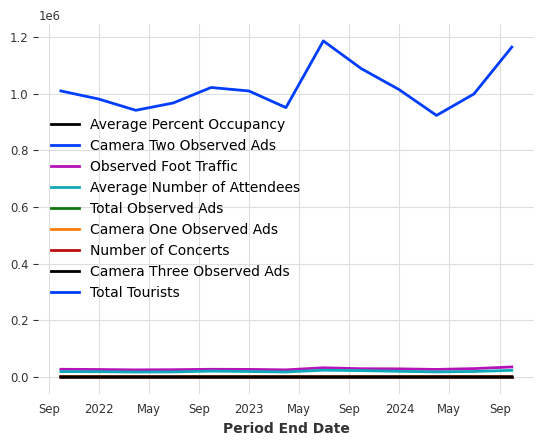

In [ ]:
covariate_cols = list(set(list(df)) - set(['Period End Date', 'Total Revenue', 'Event Ticket Sales', 'Box Office Sales', 'Advertising Sales', 'Food, Beverage, and Merchandise Sales']))

covar_series = TimeSeries.from_dataframe(df, time_col='Period End Date', value_cols=covariate_cols)
covar_series.plot()

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


XGBModel MAPE: 5.850860244494314
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 8, number of used features: 0
[LightGBM] [Info] Start training from score 3774042.875000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there

<Axes: xlabel='Period End Date'>

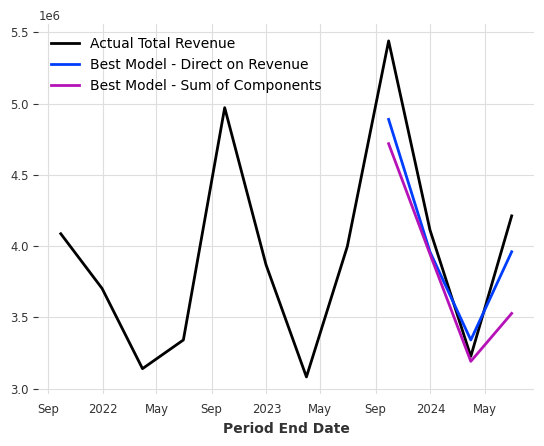

In [ ]:
from darts import TimeSeries
from darts.metrics import mape
from darts.models import XGBModel, LightGBMModel, LinearRegressionModel, RandomForest
from darts.utils.likelihood_models import QuantileRegression

# Define the models to test
models_to_test = [
    XGBModel(lags=None, lags_future_covariates=[0]),
    LightGBMModel(lags=None, lags_future_covariates=[0]),
    LinearRegressionModel(lags=None, lags_future_covariates=[0]),
    RandomForest(lags=None, lags_future_covariates=[0])
]

# Split all series into training and validation sets
train_revenue, val_revenue = revenue_series.split_after(7)
train_ticket, val_ticket = ticket_series.split_after(7)
train_merch, val_merch = merch_series.split_after(7)
train_bo, val_bo = bo_series.split_after(7)
train_advertising, val_advertising = advertising_series.split_after(7)

# Function to select the best model based on MAPE
def select_best_model(train_series, val_series, future_covariates):
    best_mape = float('inf')
    best_model = None
    best_prediction = None

    for model in models_to_test:
        # Fit the model
        model.fit(series=train_series, future_covariates=future_covariates)

        # Predict for the validation set length
        n = len(val_series)
        predictions = model.predict(n=n, future_covariates=future_covariates)

        # Calculate MAPE
        current_mape = mape(val_series, predictions)
        print(f"{model.__class__.__name__} MAPE: {current_mape}")

        # Select the model with the lowest MAPE
        if current_mape < best_mape:
            best_mape = current_mape
            best_model = model
            best_prediction = predictions

    return best_prediction, best_model

# Step 1: Select the best model directly for revenue series
best_revenue_prediction, best_revenue_model = select_best_model(train_revenue, val_revenue, covar_series)
print(f"Best model for revenue_series: {best_revenue_model.__class__.__name__}")

# Step 2: Train and select the best model for each component series
pred_ticket, best_ticket_model = select_best_model(train_ticket, val_ticket, covar_series)
pred_merch, best_merch_model = select_best_model(train_merch, val_merch, covar_series)
pred_bo, best_bo_model = select_best_model(train_bo, val_bo, covar_series)
pred_advertising, best_advertising_model = select_best_model(train_advertising, val_advertising, covar_series)

# Sum the best component predictions to estimate total revenue
total_revenue_predictions_from_components = pred_ticket + pred_merch + pred_bo + pred_advertising

# Calculate and compare MAPE for both approaches
mape_direct = mape(val_revenue, best_revenue_prediction)
mape_components = mape(val_revenue, total_revenue_predictions_from_components)

print(f"MAPE for direct revenue model: {mape_direct}")
print(f"MAPE for component-based model: {mape_components}")

# Plot comparison
revenue_series.plot(label="Actual Total Revenue")
best_revenue_prediction.plot(label="Best Model - Direct on Revenue")
total_revenue_predictions_from_components.plot(label="Best Model - Sum of Components")

<Axes: xlabel='Period End Date'>

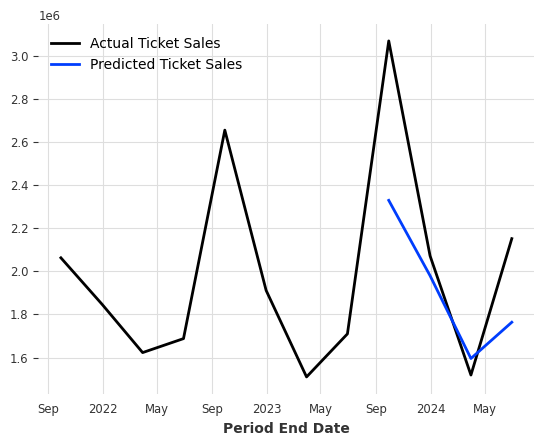

In [ ]:
ticket_series.plot(label='Actual Ticket Sales')
pred_ticket.plot(label='Predicted Ticket Sales')

<Axes: xlabel='Period End Date'>

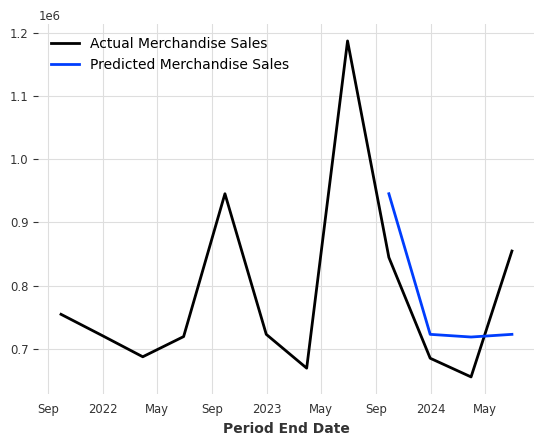

In [ ]:
merch_series.plot(label='Actual Merchandise Sales')
pred_merch.plot(label='Predicted Merchandise Sales')

<Axes: xlabel='Period End Date'>

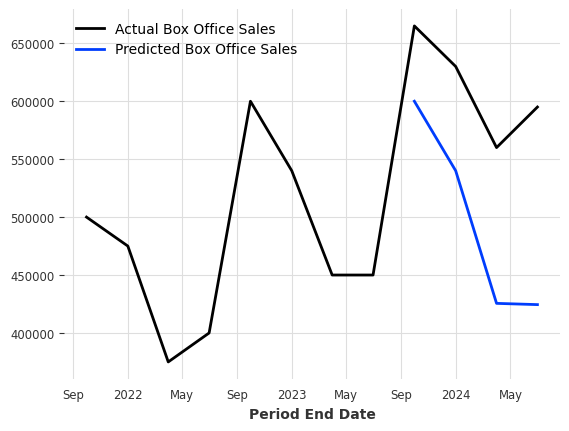

In [ ]:
bo_series.plot(label='Actual Box Office Sales')
pred_bo.plot(label='Predicted Box Office Sales')

<Axes: xlabel='Period End Date'>

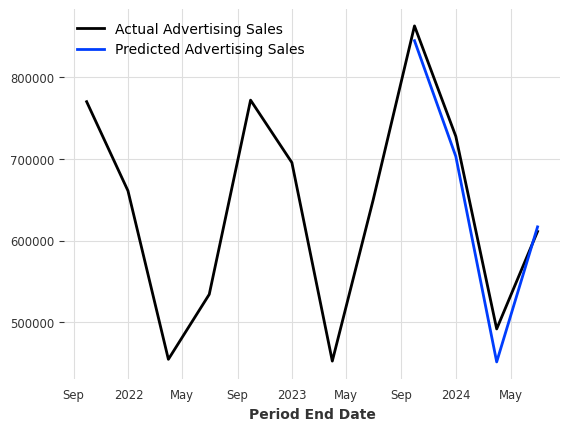

In [ ]:
advertising_series.plot(label='Actual Advertising Sales')
pred_advertising.plot(label='Predicted Advertising Sales')

In [ ]:
from darts.metrics import mql, mae

print(f"MAPE of combined forecast: {mape(revenue_series, total_revenue_predictions_from_components):.2f}")
print(f"MAE of combined forecast: {mae(revenue_series, total_revenue_predictions_from_components):.2f}")

print(f"MAPE of solo forecast: {mape(revenue_series, best_revenue_prediction):.2f}")
print(f"MAE of solo forecast: {mae(revenue_series, best_revenue_prediction):.2f}")

MAPE of combined forecast: 8.67
MAE of combined forecast: 402364.74
MAPE of solo forecast: 5.85
MAE of solo forecast: 267819.31


In [ ]:
# Determine the best approach based on MAPE
if mape_direct < mape_components:
    best_approach = "Direct Model on Revenue"
    final_model = best_revenue_model
else:
    best_approach = "Component-Based Model"
    final_model = None  # We don't have a single model for the component-based approach

print(f"The best approach based on MAPE is: {best_approach}\n")

# Train on all data and predict for the next time step
if best_approach == "Direct Model on Revenue":
    # Train the best model on the full revenue data
    final_model.fit(series=revenue_series, future_covariates=covar_series)

    # Predict the next time step based on the next covariate value
    next_prediction = final_model.predict(n=1, future_covariates=covar_series)

    print("Next prediction using the Direct Model on Revenue:")
    print(next_prediction.values().flatten()[0])
else:
    # Retrain each component model on the full component data, then sum the next predictions
    best_ticket_model.fit(series=ticket_series, future_covariates=covar_series)
    best_merch_model.fit(series=merch_series, future_covariates=covar_series)
    best_bo_model.fit(series=bo_series, future_covariates=covar_series)
    best_advertising_model.fit(series=advertising_series, future_covariates=covar_series)

    # Predict the next step for each component
    next_pred_ticket = best_ticket_model.predict(n=1, future_covariates=covar_series)
    next_pred_merch = best_merch_model.predict(n=1, future_covariates=covar_series)
    next_pred_bo = best_bo_model.predict(n=1, future_covariates=covar_series)
    next_pred_advertising = best_advertising_model.predict(n=1, future_covariates=covar_series)

    # Sum predictions to get the total revenue prediction
    next_prediction = next_pred_ticket + next_pred_merch + next_pred_bo + next_pred_advertising

    print("Next prediction using the Component-Based Model:")
    print(next_prediction.values().flatten()[0])


The best approach based on MAPE is: Direct Model on Revenue

Next prediction using the Direct Model on Revenue:
5440160.5
